# Import packages

In [2]:
import numpy as np
import pandas as pd
import torch
import os
import pickle
import sys  
from torch import nn, Tensor

In [3]:
sys.path.insert(0, '/home/jovyan/workspace/g2b2/fshokor/PhD/DL_GP_PhD/Public/DL_Model')
import utils
import training
import models

In [4]:
torch.cuda.is_available()

True

# Load Data

In [46]:
os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))

'/home/jovyan/workspace/g2b2/fshokor/PhD'

In [5]:
# Phenotypes
pheno = pd.read_csv("/home/jovyan/workspace/g2b2/fshokor/PhD/DL_GP_PhD/Public/Data/Pheno_G0_25K.csv")

# GBLUP predicted Genetic Value
gblup = pd.read_csv("/home/jovyan/workspace/g2b2/fshokor/PhD/DL_GP_PhD/Public/Data/PGV_MTGBLUP_G0_25K.csv")

# True Genetic Value
gv = pd.read_csv('/home/jovyan/workspace/g2b2/fshokor/PhD/DL_GP_PhD/Public/Data/TGV_G0_25K.csv')

# Genotypes
geno = pd.read_csv("/home/jovyan/workspace/g2b2/fshokor/PhD/DL_GP_PhD/Public/Data/Geno_jQTL_25K.txt", sep=' ', header = None)

# Split data

## DL Model 

Split data for Deep Learning model that use only the phenotype for prediction

In [6]:
train_loader_DL = utils.GetDataLoaderMT(features = geno[:20000], 
                                         targets = np.concatenate((np.array(pheno), np.array(pheno)), axis=1)[:20000], 
                                         batch_size = 200)
val_loader_DL = utils.GetDataLoaderMT(features = geno[20000:22500], 
                                       targets = np.concatenate((np.array(pheno), np.array(pheno)), axis=1)[20000:22500], 
                                       batch_size = 200)
test_loader_DL = utils.GetDataLoaderMT(features = geno[22500:], 
                                        targets = np.concatenate((np.array(pheno), np.array(pheno)), axis=1)[22500:], 
                                        batch_size = 200)

In [7]:
data_loaders_DL = {"train": train_loader_DL, "val": val_loader_DL}

## Common

In [9]:
for data in train_loader_DL:
    x = data[0]
    y =data[1]
    break

In [10]:
print('Input shape: ', x.shape, ' Output shape: ', y.shape)

Input shape:  torch.Size([200, 759])  Output shape:  torch.Size([200, 12])


In [11]:
device = utils.get_default_device()

In [12]:
devicecpu = torch.device("cpu")

In [13]:
device

device(type='cuda')

# Prediction Model

In [14]:
snps_number = len(geno.columns)
hidden_layer_1 = 400
hidden_layer_2 = 256
traits_number = len(pheno.columns)

In [15]:
prediction_model = models.DL_Prediction_Model(snps_number, traits_number, hidden_layer_1, hidden_layer_2)
print(prediction_model)

DL_Prediction_Model(
  (net1): Sequential(
    (0): Linear(in_features=759, out_features=400, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=400, out_features=6, bias=True)
  )
  (trait2traitnet): Sequential(
    (0): Linear(in_features=6, out_features=400, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=400, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=256, out_features=6, bias=True)
  )
)


## Training

In [16]:
# Count model parameters
utils.count_parameters(prediction_model)

413404

In [17]:
# Define Adam optimizer
optimizer = torch.optim.Adam(prediction_model.parameters(), lr=1e-4)

In [18]:
# Train prediction model and save the history 
history = training.fitMT( model = prediction_model, data = data_loaders_DL, optimizer = optimizer, num_epochs = 100, patience = 10, checkpoint_path = 'checkpoint.pt', device = device)

Starting Training ...
Starting epoch 1


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	cor_Loss1: -0.2101	mse_loss1: 4.2823	cor_Loss2: 0.0000	mse_loss2: 0.0000


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	cor_Loss1: 0.4976	mse_loss1: 3.5541	cor_Loss2: 0.0000	mse_loss2: 0.0000
Starting epoch 2


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	cor_Loss1: 0.5506	mse_loss1: 3.3855	cor_Loss2: 0.0000	mse_loss2: 0.0000


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	cor_Loss1: 0.5549	mse_loss1: 3.3517	cor_Loss2: 0.0000	mse_loss2: 0.0000
Starting epoch 3


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	cor_Loss1: 0.5673	mse_loss1: 3.2950	cor_Loss2: 0.0000	mse_loss2: 0.0000


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	cor_Loss1: 0.5747	mse_loss1: 3.2578	cor_Loss2: 0.0000	mse_loss2: 0.0000
Module 1 loss has stabilized. Starting training for Module 2.
Starting epoch 4


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	cor_Loss1: 0.5862	mse_loss1: 3.2103	cor_Loss2: -0.4217	mse_loss2: 3.9053
Validation loss decreased (inf --> 3.905260).  Saving model ...


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	cor_Loss1: 0.5948	mse_loss1: 3.1790	cor_Loss2: 0.5121	mse_loss2: 3.1680
Starting epoch 5


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	cor_Loss1: 0.6038	mse_loss1: 3.1491	cor_Loss2: 0.5837	mse_loss2: 2.9774
Validation loss decreased (3.905260 --> 2.977376).  Saving model ...


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	cor_Loss1: 0.6127	mse_loss1: 3.1135	cor_Loss2: 0.5925	mse_loss2: 2.9458
Starting epoch 6


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	cor_Loss1: 0.6198	mse_loss1: 3.0912	cor_Loss2: 0.6040	mse_loss2: 2.9144
Validation loss decreased (2.977376 --> 2.914447).  Saving model ...


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	cor_Loss1: 0.6285	mse_loss1: 3.0545	cor_Loss2: 0.6165	mse_loss2: 2.8675
Starting epoch 7


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	cor_Loss1: 0.6333	mse_loss1: 3.0440	cor_Loss2: 0.6299	mse_loss2: 2.8314
Validation loss decreased (2.914447 --> 2.831393).  Saving model ...


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	cor_Loss1: 0.6421	mse_loss1: 3.0056	cor_Loss2: 0.6446	mse_loss2: 2.7693
Starting epoch 8


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	cor_Loss1: 0.6443	mse_loss1: 3.0046	cor_Loss2: 0.6513	mse_loss2: 2.7511
Validation loss decreased (2.831393 --> 2.751050).  Saving model ...


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	cor_Loss1: 0.6537	mse_loss1: 2.9621	cor_Loss2: 0.6622	mse_loss2: 2.7014
Starting epoch 9


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	cor_Loss1: 0.6531	mse_loss1: 2.9692	cor_Loss2: 0.6607	mse_loss2: 2.7139
Validation loss decreased (2.751050 --> 2.713916).  Saving model ...


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	cor_Loss1: 0.6631	mse_loss1: 2.9225	cor_Loss2: 0.6720	mse_loss2: 2.6622
Starting epoch 10


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	cor_Loss1: 0.6601	mse_loss1: 2.9381	cor_Loss2: 0.6670	mse_loss2: 2.6911
Validation loss decreased (2.713916 --> 2.691086).  Saving model ...


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	cor_Loss1: 0.6706	mse_loss1: 2.8881	cor_Loss2: 0.6789	mse_loss2: 2.6344
Starting epoch 11


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	cor_Loss1: 0.6655	mse_loss1: 2.9130	cor_Loss2: 0.6716	mse_loss2: 2.6743
Validation loss decreased (2.691086 --> 2.674256).  Saving model ...


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	cor_Loss1: 0.6765	mse_loss1: 2.8594	cor_Loss2: 0.6837	mse_loss2: 2.6144
Starting epoch 12


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	cor_Loss1: 0.6696	mse_loss1: 2.8925	cor_Loss2: 0.6748	mse_loss2: 2.6622
Validation loss decreased (2.674256 --> 2.662153).  Saving model ...


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	cor_Loss1: 0.6811	mse_loss1: 2.8358	cor_Loss2: 0.6873	mse_loss2: 2.5991
Starting epoch 13


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	cor_Loss1: 0.6726	mse_loss1: 2.8763	cor_Loss2: 0.6771	mse_loss2: 2.6531
Validation loss decreased (2.662153 --> 2.653061).  Saving model ...


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	cor_Loss1: 0.6846	mse_loss1: 2.8164	cor_Loss2: 0.6901	mse_loss2: 2.5868
Starting epoch 14


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	cor_Loss1: 0.6748	mse_loss1: 2.8633	cor_Loss2: 0.6789	mse_loss2: 2.6459
Validation loss decreased (2.653061 --> 2.645928).  Saving model ...


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	cor_Loss1: 0.6873	mse_loss1: 2.8003	cor_Loss2: 0.6924	mse_loss2: 2.5768
Starting epoch 15


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	cor_Loss1: 0.6764	mse_loss1: 2.8527	cor_Loss2: 0.6803	mse_loss2: 2.6402
Validation loss decreased (2.645928 --> 2.640193).  Saving model ...


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	cor_Loss1: 0.6895	mse_loss1: 2.7867	cor_Loss2: 0.6943	mse_loss2: 2.5682
Starting epoch 16


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	cor_Loss1: 0.6777	mse_loss1: 2.8439	cor_Loss2: 0.6815	mse_loss2: 2.6356
Validation loss decreased (2.640193 --> 2.635586).  Saving model ...


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	cor_Loss1: 0.6912	mse_loss1: 2.7751	cor_Loss2: 0.6959	mse_loss2: 2.5609
Starting epoch 17


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	cor_Loss1: 0.6786	mse_loss1: 2.8366	cor_Loss2: 0.6825	mse_loss2: 2.6319
Validation loss decreased (2.635586 --> 2.631892).  Saving model ...


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	cor_Loss1: 0.6926	mse_loss1: 2.7650	cor_Loss2: 0.6973	mse_loss2: 2.5545
Starting epoch 18


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	cor_Loss1: 0.6793	mse_loss1: 2.8303	cor_Loss2: 0.6833	mse_loss2: 2.6286
Validation loss decreased (2.631892 --> 2.628630).  Saving model ...


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	cor_Loss1: 0.6938	mse_loss1: 2.7562	cor_Loss2: 0.6985	mse_loss2: 2.5488
Starting epoch 19


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	cor_Loss1: 0.6799	mse_loss1: 2.8250	cor_Loss2: 0.6839	mse_loss2: 2.6261
Validation loss decreased (2.628630 --> 2.626102).  Saving model ...


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	cor_Loss1: 0.6947	mse_loss1: 2.7484	cor_Loss2: 0.6996	mse_loss2: 2.5439
Starting epoch 20


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	cor_Loss1: 0.6803	mse_loss1: 2.8204	cor_Loss2: 0.6844	mse_loss2: 2.6242
Validation loss decreased (2.626102 --> 2.624150).  Saving model ...


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	cor_Loss1: 0.6955	mse_loss1: 2.7414	cor_Loss2: 0.7005	mse_loss2: 2.5395
Starting epoch 21


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	cor_Loss1: 0.6806	mse_loss1: 2.8163	cor_Loss2: 0.6849	mse_loss2: 2.6226
Validation loss decreased (2.624150 --> 2.622562).  Saving model ...


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	cor_Loss1: 0.6962	mse_loss1: 2.7352	cor_Loss2: 0.7013	mse_loss2: 2.5357
Starting epoch 22


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	cor_Loss1: 0.6808	mse_loss1: 2.8126	cor_Loss2: 0.6852	mse_loss2: 2.6211
Validation loss decreased (2.622562 --> 2.621145).  Saving model ...


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	cor_Loss1: 0.6968	mse_loss1: 2.7294	cor_Loss2: 0.7020	mse_loss2: 2.5322
Starting epoch 23


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	cor_Loss1: 0.6810	mse_loss1: 2.8093	cor_Loss2: 0.6855	mse_loss2: 2.6200
Validation loss decreased (2.621145 --> 2.620030).  Saving model ...


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	cor_Loss1: 0.6973	mse_loss1: 2.7242	cor_Loss2: 0.7026	mse_loss2: 2.5291
Starting epoch 24


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	cor_Loss1: 0.6812	mse_loss1: 2.8062	cor_Loss2: 0.6858	mse_loss2: 2.6192
Validation loss decreased (2.620030 --> 2.619207).  Saving model ...


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	cor_Loss1: 0.6977	mse_loss1: 2.7193	cor_Loss2: 0.7032	mse_loss2: 2.5262
Starting epoch 25


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	cor_Loss1: 0.6813	mse_loss1: 2.8034	cor_Loss2: 0.6860	mse_loss2: 2.6184
Validation loss decreased (2.619207 --> 2.618420).  Saving model ...


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	cor_Loss1: 0.6981	mse_loss1: 2.7148	cor_Loss2: 0.7037	mse_loss2: 2.5237
Starting epoch 26


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	cor_Loss1: 0.6814	mse_loss1: 2.8008	cor_Loss2: 0.6862	mse_loss2: 2.6179
Validation loss decreased (2.618420 --> 2.617944).  Saving model ...


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	cor_Loss1: 0.6985	mse_loss1: 2.7106	cor_Loss2: 0.7041	mse_loss2: 2.5214
Starting epoch 27


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	cor_Loss1: 0.6814	mse_loss1: 2.7984	cor_Loss2: 0.6864	mse_loss2: 2.6176
Validation loss decreased (2.617944 --> 2.617570).  Saving model ...


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	cor_Loss1: 0.6988	mse_loss1: 2.7067	cor_Loss2: 0.7045	mse_loss2: 2.5193
Starting epoch 28


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	cor_Loss1: 0.6815	mse_loss1: 2.7962	cor_Loss2: 0.6865	mse_loss2: 2.6172
Validation loss decreased (2.617570 --> 2.617151).  Saving model ...


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	cor_Loss1: 0.6991	mse_loss1: 2.7029	cor_Loss2: 0.7049	mse_loss2: 2.5174
Starting epoch 29


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	cor_Loss1: 0.6815	mse_loss1: 2.7941	cor_Loss2: 0.6866	mse_loss2: 2.6168
Validation loss decreased (2.617151 --> 2.616842).  Saving model ...


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	cor_Loss1: 0.6993	mse_loss1: 2.6994	cor_Loss2: 0.7053	mse_loss2: 2.5156
Starting epoch 30


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	cor_Loss1: 0.6815	mse_loss1: 2.7921	cor_Loss2: 0.6867	mse_loss2: 2.6167
Validation loss decreased (2.616842 --> 2.616707).  Saving model ...


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	cor_Loss1: 0.6996	mse_loss1: 2.6961	cor_Loss2: 0.7056	mse_loss2: 2.5140
Starting epoch 31


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	cor_Loss1: 0.6816	mse_loss1: 2.7902	cor_Loss2: 0.6868	mse_loss2: 2.6166
Validation loss decreased (2.616707 --> 2.616587).  Saving model ...


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	cor_Loss1: 0.6998	mse_loss1: 2.6929	cor_Loss2: 0.7058	mse_loss2: 2.5124
Starting epoch 32


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	cor_Loss1: 0.6816	mse_loss1: 2.7883	cor_Loss2: 0.6868	mse_loss2: 2.6164
Validation loss decreased (2.616587 --> 2.616407).  Saving model ...


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	cor_Loss1: 0.7000	mse_loss1: 2.6899	cor_Loss2: 0.7061	mse_loss2: 2.5110
Starting epoch 33


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	cor_Loss1: 0.6816	mse_loss1: 2.7866	cor_Loss2: 0.6869	mse_loss2: 2.6164
Validation loss decreased (2.616407 --> 2.616357).  Saving model ...


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	cor_Loss1: 0.7002	mse_loss1: 2.6870	cor_Loss2: 0.7063	mse_loss2: 2.5097
Starting epoch 34


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	cor_Loss1: 0.6816	mse_loss1: 2.7850	cor_Loss2: 0.6869	mse_loss2: 2.6163
Validation loss decreased (2.616357 --> 2.616340).  Saving model ...


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	cor_Loss1: 0.7004	mse_loss1: 2.6843	cor_Loss2: 0.7066	mse_loss2: 2.5085
Starting epoch 35


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	cor_Loss1: 0.6816	mse_loss1: 2.7834	cor_Loss2: 0.6870	mse_loss2: 2.6163
Validation loss decreased (2.616340 --> 2.616325).  Saving model ...


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	cor_Loss1: 0.7006	mse_loss1: 2.6816	cor_Loss2: 0.7068	mse_loss2: 2.5073
Starting epoch 36


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	cor_Loss1: 0.6816	mse_loss1: 2.7818	cor_Loss2: 0.6871	mse_loss2: 2.6163
Validation loss decreased (2.616325 --> 2.616280).  Saving model ...


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	cor_Loss1: 0.7007	mse_loss1: 2.6791	cor_Loss2: 0.7070	mse_loss2: 2.5062
Starting epoch 37


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	cor_Loss1: 0.6817	mse_loss1: 2.7804	cor_Loss2: 0.6871	mse_loss2: 2.6163
EarlyStopping counter: 1 out of 10


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	cor_Loss1: 0.7009	mse_loss1: 2.6766	cor_Loss2: 0.7072	mse_loss2: 2.5051
Starting epoch 38


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	cor_Loss1: 0.6817	mse_loss1: 2.7790	cor_Loss2: 0.6871	mse_loss2: 2.6164
EarlyStopping counter: 2 out of 10


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	cor_Loss1: 0.7011	mse_loss1: 2.6742	cor_Loss2: 0.7074	mse_loss2: 2.5040
Starting epoch 39


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	cor_Loss1: 0.6817	mse_loss1: 2.7778	cor_Loss2: 0.6871	mse_loss2: 2.6166
EarlyStopping counter: 3 out of 10


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	cor_Loss1: 0.7012	mse_loss1: 2.6719	cor_Loss2: 0.7075	mse_loss2: 2.5031
Starting epoch 40


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	cor_Loss1: 0.6817	mse_loss1: 2.7765	cor_Loss2: 0.6871	mse_loss2: 2.6168
EarlyStopping counter: 4 out of 10


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	cor_Loss1: 0.7014	mse_loss1: 2.6697	cor_Loss2: 0.7077	mse_loss2: 2.5022
Starting epoch 41


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	cor_Loss1: 0.6817	mse_loss1: 2.7753	cor_Loss2: 0.6871	mse_loss2: 2.6169
EarlyStopping counter: 5 out of 10


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	cor_Loss1: 0.7015	mse_loss1: 2.6676	cor_Loss2: 0.7078	mse_loss2: 2.5013
Starting epoch 42


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	cor_Loss1: 0.6817	mse_loss1: 2.7741	cor_Loss2: 0.6871	mse_loss2: 2.6170
EarlyStopping counter: 6 out of 10


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	cor_Loss1: 0.7017	mse_loss1: 2.6655	cor_Loss2: 0.7080	mse_loss2: 2.5004
Starting epoch 43


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	cor_Loss1: 0.6817	mse_loss1: 2.7730	cor_Loss2: 0.6872	mse_loss2: 2.6172
EarlyStopping counter: 7 out of 10


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	cor_Loss1: 0.7018	mse_loss1: 2.6634	cor_Loss2: 0.7081	mse_loss2: 2.4995
Starting epoch 44


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	cor_Loss1: 0.6818	mse_loss1: 2.7718	cor_Loss2: 0.6872	mse_loss2: 2.6173
EarlyStopping counter: 8 out of 10


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	cor_Loss1: 0.7020	mse_loss1: 2.6614	cor_Loss2: 0.7083	mse_loss2: 2.4987
Starting epoch 45


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	cor_Loss1: 0.6818	mse_loss1: 2.7708	cor_Loss2: 0.6872	mse_loss2: 2.6175
EarlyStopping counter: 9 out of 10


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	cor_Loss1: 0.7022	mse_loss1: 2.6595	cor_Loss2: 0.7084	mse_loss2: 2.4979
Starting epoch 46


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	cor_Loss1: 0.6818	mse_loss1: 2.7697	cor_Loss2: 0.6871	mse_loss2: 2.6178
EarlyStopping counter: 10 out of 10
Early stopping


## Plot loss

In [19]:
history.keys()

dict_keys(['cor_loss1', 'mse_loss1', 'cor_loss2', 'mse_loss2', 'val_cor_loss1', 'val_mse_loss1', 'val_cor_loss2', 'val_mse_loss2', 'train_epoch_cor_loss1', 'train_epoch_mse_loss1', 'train_epoch_cor_loss2', 'train_epoch_mse_loss2', 'val_epoch_cor_loss1', 'val_epoch_mse_loss1', 'val_epoch_cor_loss2', 'val_epoch_mse_loss2'])

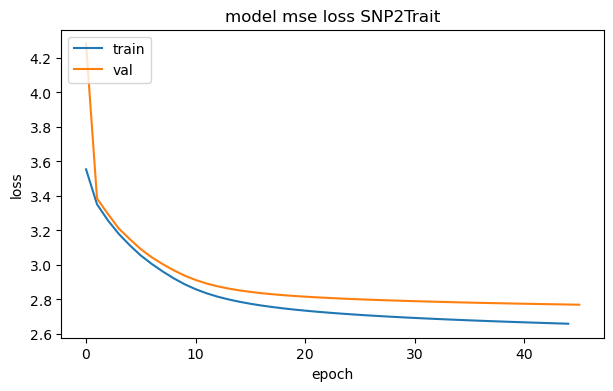

In [20]:
utils.plot_learning_curve(history['mse_loss1'], history['val_mse_loss1'], 'model mse loss SNP2Trait')

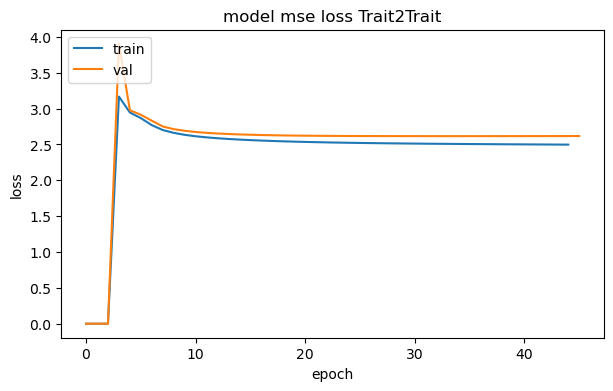

In [21]:
utils.plot_learning_curve(history['mse_loss2'], history['val_mse_loss2'], 'model mse loss Trait2Trait')

## Prediction

In [22]:
utils.to_device(prediction_model,devicecpu)

DL_Prediction_Model(
  (net1): Sequential(
    (0): Linear(in_features=759, out_features=400, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=400, out_features=6, bias=True)
  )
  (trait2traitnet): Sequential(
    (0): Linear(in_features=6, out_features=400, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=400, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=256, out_features=6, bias=True)
  )
)

In [23]:
res_test = utils.PredictBV(prediction_model, test_loader_DL)
res_train = utils.PredictBV(prediction_model, train_loader_DL)
res_val = utils.PredictBV(prediction_model, val_loader_DL)

## Evaluation

In [24]:
# prediction evaluation between the TGV and the results of SNP2Trait module
utils.evaluateMT(gv.iloc[22500:], res_test[0])

,Correlation,MSE,Slope,Standard error,Variance Real,Variance GEBV
0,0.95,0.63,0.95,0.01,5.72,5.71
1,0.94,0.63,0.97,0.01,5.70,5.41
2,0.82,1.89,0.94,0.01,5.73,4.41
3,0.80,2.16,0.92,0.01,5.86,4.43
4,0.94,0.69,0.97,0.01,5.77,5.41
5,0.91,0.96,0.95,0.01,5.77,5.31


In [25]:
# prediction evaluation between the TGV and the results of Trait2Trait module
utils.evaluateMT(gv.iloc[22500:], res_test[1])

,Correlation,MSE,Slope,Standard error,Variance Real,Variance GEBV
0,0.94,0.70,0.90,0.01,5.72,6.24
1,0.94,0.67,0.93,0.01,5.70,5.90
2,0.91,1.05,0.95,0.01,5.73,5.28
3,0.84,1.98,0.90,0.01,5.86,5.09
4,0.94,0.69,0.93,0.01,5.77,5.93
5,0.93,0.87,0.92,0.01,5.77,5.87


In [26]:
# prediction evaluation between the TGV and the results of GBLUP
utils.evaluateMT(gv.iloc[22500:], gblup.iloc[22500:])

,Correlation,MSE,Slope,Standard error,Variance Real,Variance GEBV
0,0.97,0.37,0.99,0.01,5.72,5.47
1,0.97,2.73,1.01,0.01,5.70,5.28
2,0.83,11.08,1.00,0.01,5.73,3.99
3,0.83,5.96,1.01,0.01,5.86,4.00
4,0.96,48.14,1.00,0.01,5.77,5.28
5,0.93,0.93,0.97,0.01,5.77,5.32


# Training Mean Model

In [27]:
# Define model
mean_model = models.MeanTrai2Trait(traits_number, hidden_layer_1, hidden_layer_2)
print(mean_model)

MeanTrai2Trait(
  (meantrait2traitnet): Sequential(
    (0): Linear(in_features=1, out_features=400, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=400, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=256, out_features=6, bias=True)
  )
)


In [28]:
# Split data into three set, the input is the predicted genetic value of first (reference) trait of SNP2Trait module 
train_loader_mean = utils.GetDataLoaderMT(features = res_train[0].iloc[:, 0], 
                                         targets = np.array(pheno)[:20000], 
                                         batch_size = 200)
val_loader_mean = utils.GetDataLoaderMT(features = res_val[0].iloc[:, 0], 
                                       targets = np.array(pheno)[20000:22500], 
                                       batch_size = 200)
test_loader_mean = utils.GetDataLoaderMT(features = res_test[0].iloc[:, 0], 
                                        targets = np.array(pheno)[22500:], 
                                        batch_size = 200)

In [29]:
data_loaders_mean = {"train": train_loader_mean, "val": val_loader_mean}

In [30]:
utils.count_parameters(mean_model)

104998

In [31]:
optimizer_mean = torch.optim.Adam(mean_model.parameters(), lr=1e-4)

In [32]:
history_mean = training.fitMeanTrait2Trait( model = mean_model, data = data_loaders_mean, optimizer = optimizer_mean, num_epochs = 100, patience = 10, checkpoint_path = 'checkpoint_mean.pt', device = device)

Starting Training ...
Starting epoch 1


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	mse_loss1: 3.9489
Validation loss decreased (inf --> 3.948882).  Saving model ...


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	mse_loss1: 3.3101
Starting epoch 2


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	mse_loss1: 3.0204
Validation loss decreased (3.948882 --> 3.020395).  Saving model ...


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	mse_loss1: 2.9706
Starting epoch 3


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	mse_loss1: 2.9521
Validation loss decreased (3.020395 --> 2.952055).  Saving model ...


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	mse_loss1: 2.9257
Starting epoch 4


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	mse_loss1: 2.9338
Validation loss decreased (2.952055 --> 2.933758).  Saving model ...


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	mse_loss1: 2.9162
Starting epoch 5


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	mse_loss1: 2.9301
Validation loss decreased (2.933758 --> 2.930075).  Saving model ...


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	mse_loss1: 2.9138
Starting epoch 6


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	mse_loss1: 2.9286
Validation loss decreased (2.930075 --> 2.928598).  Saving model ...


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	mse_loss1: 2.9125
Starting epoch 7


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	mse_loss1: 2.9279
Validation loss decreased (2.928598 --> 2.927898).  Saving model ...


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	mse_loss1: 2.9118
Starting epoch 8


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	mse_loss1: 2.9275
Validation loss decreased (2.927898 --> 2.927488).  Saving model ...


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	mse_loss1: 2.9113
Starting epoch 9


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	mse_loss1: 2.9274
Validation loss decreased (2.927488 --> 2.927358).  Saving model ...


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	mse_loss1: 2.9109
Starting epoch 10


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	mse_loss1: 2.9273
Validation loss decreased (2.927358 --> 2.927318).  Saving model ...


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	mse_loss1: 2.9107
Starting epoch 11


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	mse_loss1: 2.9273
EarlyStopping counter: 1 out of 10


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	mse_loss1: 2.9105
Starting epoch 12


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	mse_loss1: 2.9274
EarlyStopping counter: 2 out of 10


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	mse_loss1: 2.9104
Starting epoch 13


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	mse_loss1: 2.9274
EarlyStopping counter: 3 out of 10


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	mse_loss1: 2.9103
Starting epoch 14


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	mse_loss1: 2.9274
EarlyStopping counter: 4 out of 10


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	mse_loss1: 2.9102
Starting epoch 15


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	mse_loss1: 2.9274
EarlyStopping counter: 5 out of 10


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	mse_loss1: 2.9101
Starting epoch 16


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	mse_loss1: 2.9274
EarlyStopping counter: 6 out of 10


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	mse_loss1: 2.9100
Starting epoch 17


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	mse_loss1: 2.9274
EarlyStopping counter: 7 out of 10


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	mse_loss1: 2.9099
Starting epoch 18


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	mse_loss1: 2.9274
EarlyStopping counter: 8 out of 10


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	mse_loss1: 2.9099
Starting epoch 19


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	mse_loss1: 2.9274
EarlyStopping counter: 9 out of 10


  0%|          | 0/100 [00:00<?, ?it/s]

train: 	mse_loss1: 2.9098
Starting epoch 20


  0%|          | 0/13 [00:00<?, ?it/s]

val: 	mse_loss1: 2.9275
EarlyStopping counter: 10 out of 10
Early stopping


## Prediction

In [33]:
utils.to_device(mean_model,devicecpu)

MeanTrai2Trait(
  (meantrait2traitnet): Sequential(
    (0): Linear(in_features=1, out_features=400, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=400, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=256, out_features=6, bias=True)
  )
)

In [34]:
res3_test = pd.DataFrame(utils.PredictBV(mean_model, test_loader_mean)[0])

# PLots

PLots relationship between the reference trait and all dependent traits

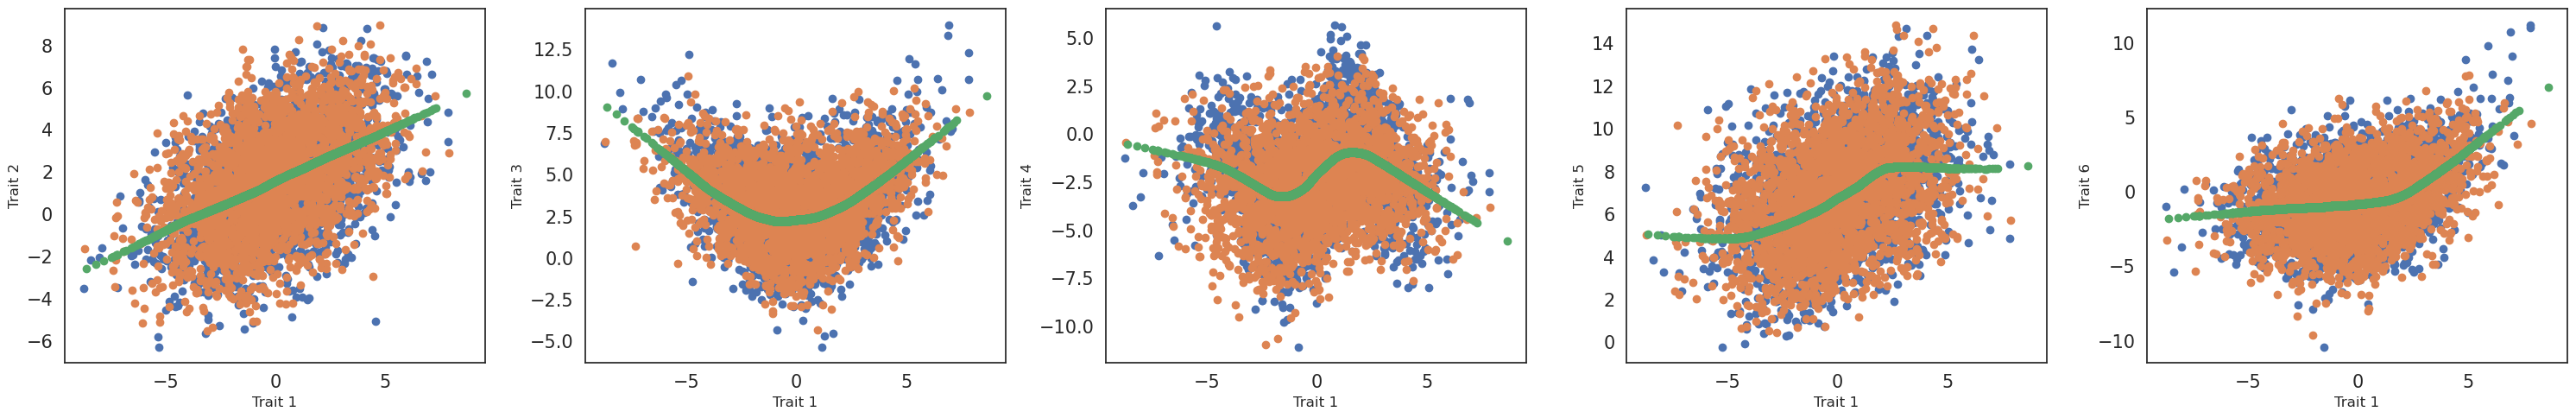

In [35]:
# True Genetic Value Value, predicted genetic value Trait2Trait, predicted mean relationship 
utils.plot_Traits(gv.iloc[22500:], res_test[1], res3_test)

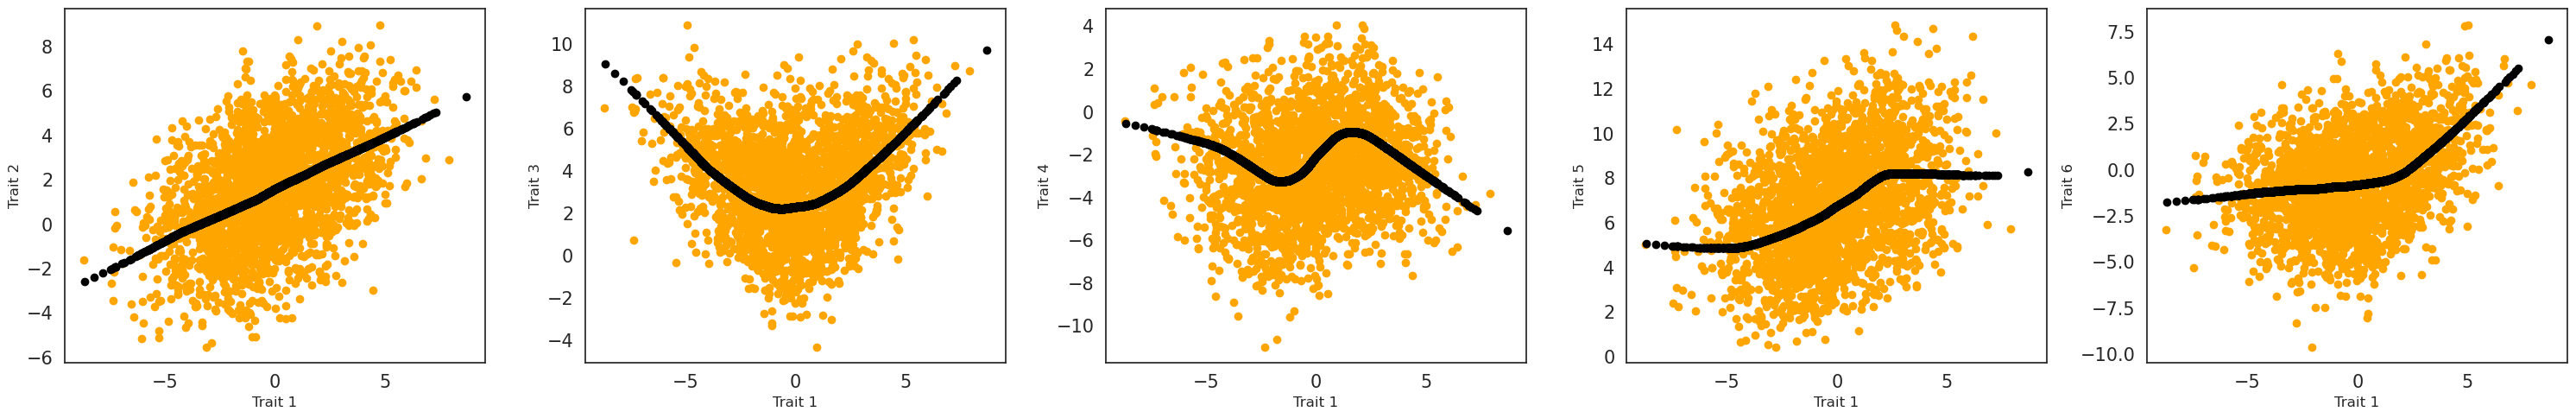

In [42]:
# predicted genetic value Trait2Trait, predicted mean relationship 
utils.plot_Traits(res_test[1], res3_test, colors=['orange', 'black'])

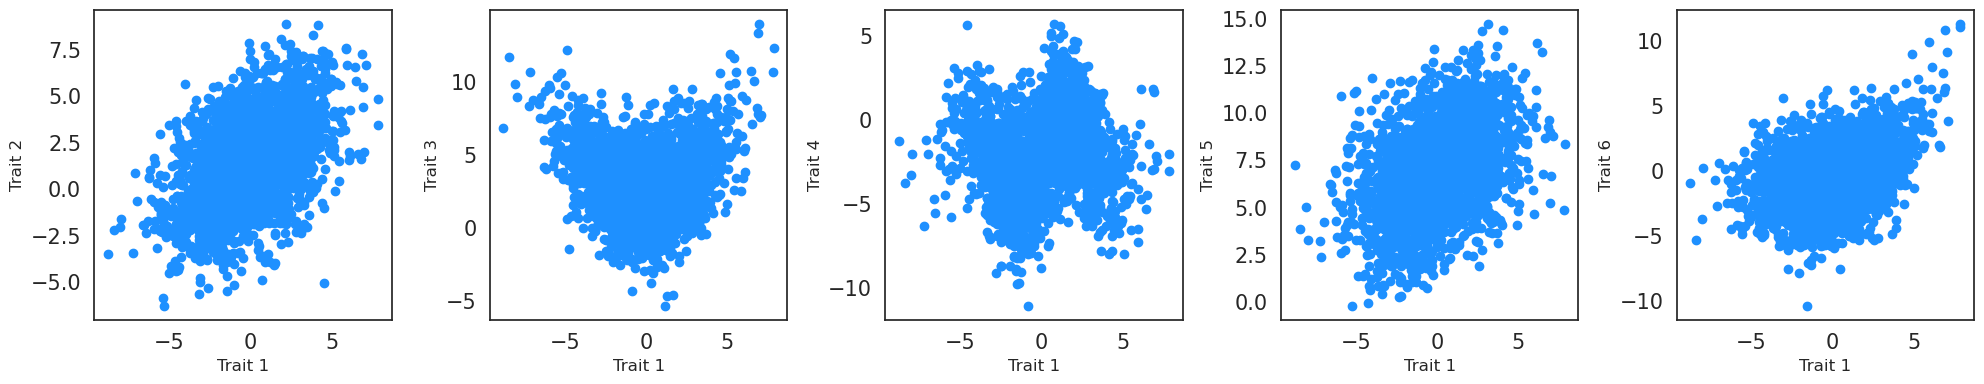

In [37]:
# True genetic value Trait2Trait
utils.plot_Traits(gv.iloc[22500:], colors=['dodgerblue'], plot_size=(20, 4))

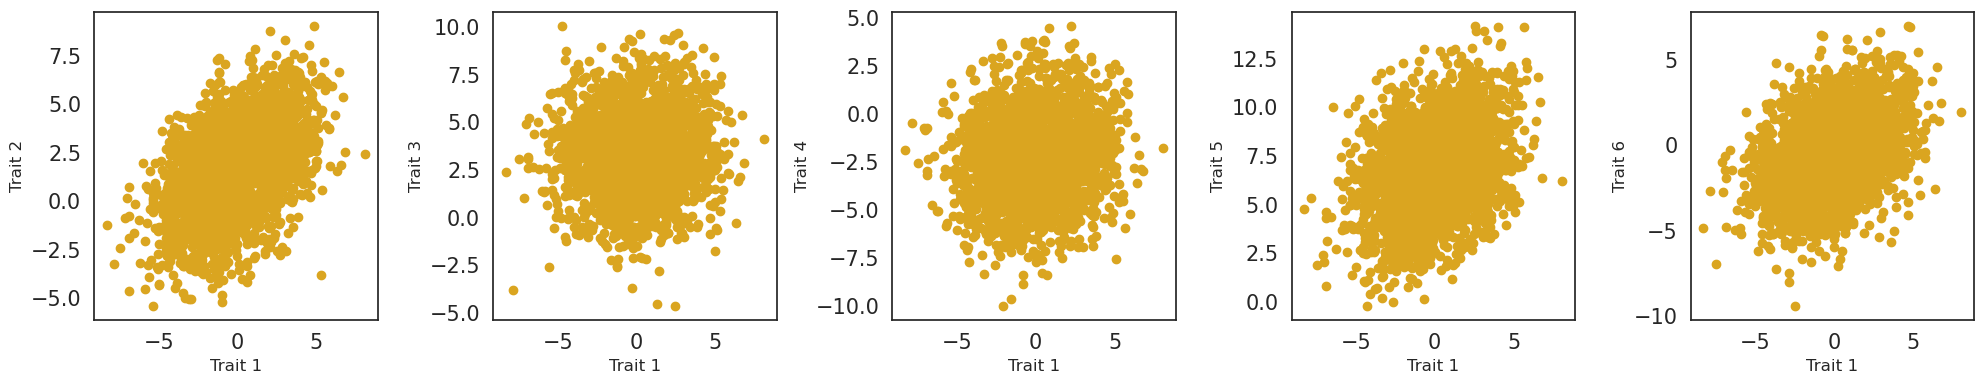

In [41]:
# predicted genetic value SNP2Trait
utils.plot_Traits(res_test[0], colors=['goldenrod'], plot_size=(20, 4))

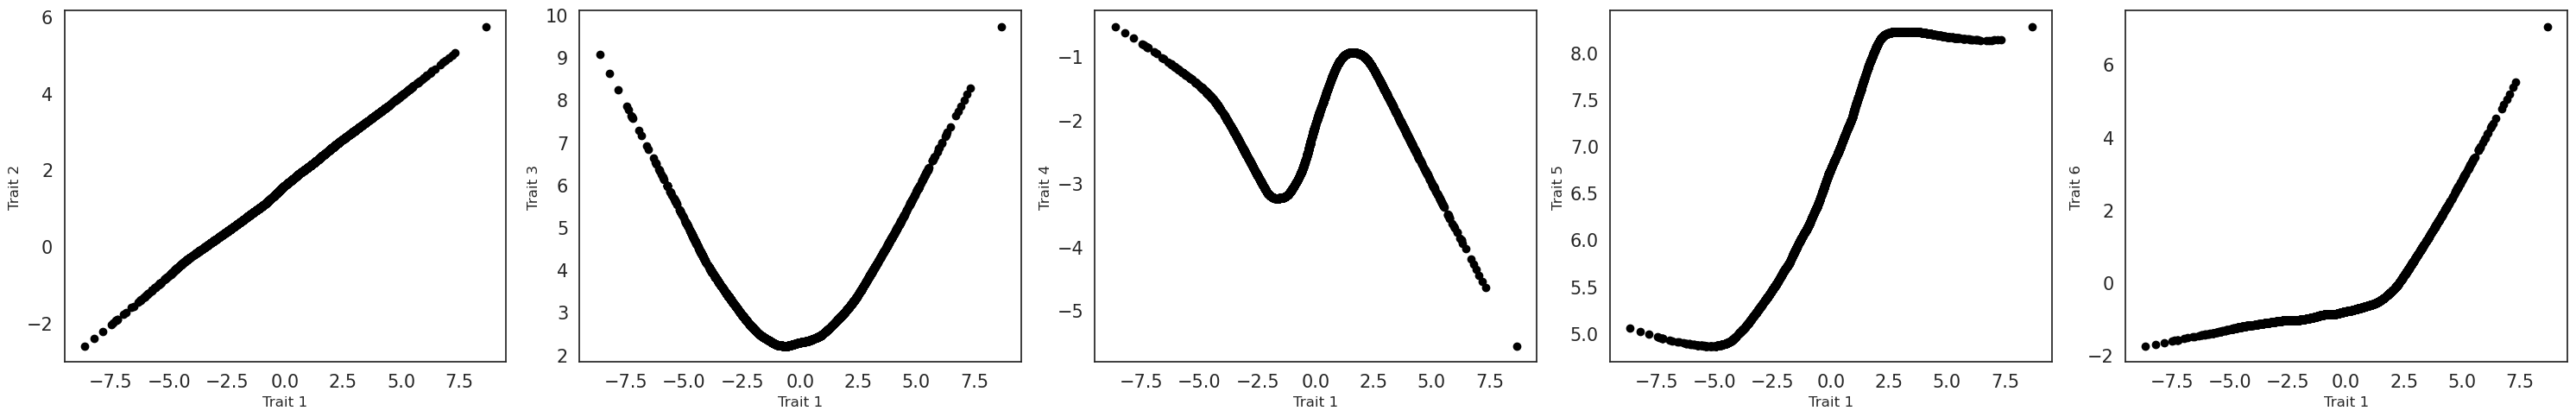

In [43]:
# predicted mean relationship 
utils.plot_Traits(res3_test, colors=['black'])

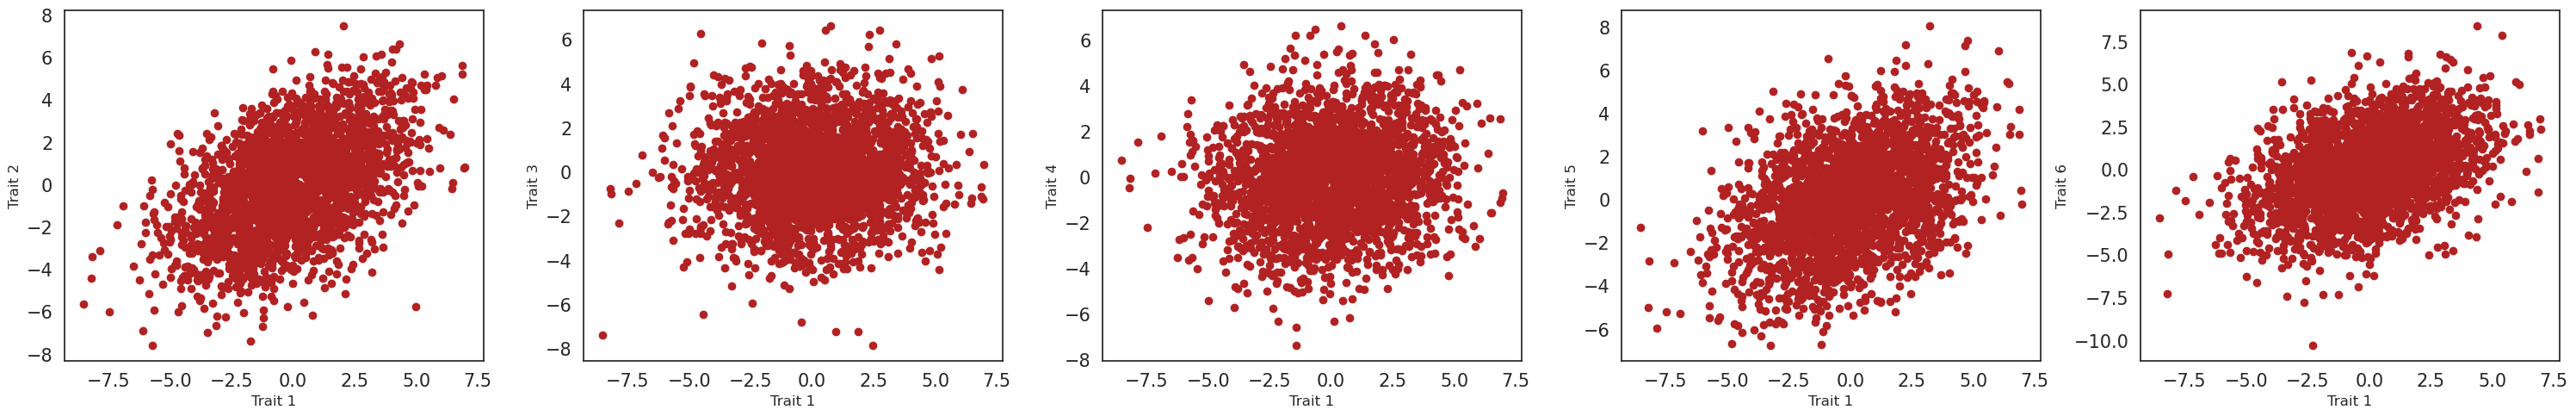

In [44]:
# predicted genetic value GBLUP
utils.plot_Traits(gblup[22500:], colors=['firebrick'])